**Introduction to Python for Economists** <br>
Authors: Marco Valentino Caravella (0001134954) Damiano Mongiello (0001129786) <br>
Date: 20/01/2025

In [1]:
import pandas as pd 
import os
import geopandas as gpd 
import matplotlib.pyplot as plt 
from shapely.geometry import Point 
from shapely.geometry import box
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

We start by loading all the datasets needed for the research analysis, and proceed with the data cleaning operations.

In [2]:
# Set the working directory
os.chdir('C:/Users/user/Documents/Unibo/Economics and Econometrics/Second Year/First Semester/Introduction to Python for Economists/Project')

# Load Nuclear Plants data
nuclear_plants = pd.read_csv('nuclear_power_plants.csv') # data from "https://github.com/cristianst85/GeoNuclearData/blob/master/data/csv/denormalized/nuclear_power_plants.csv"
print(nuclear_plants.head())

# Consider only nuclear plants that are already operative
operational_nuclear_plants = ["Operational"]
nuclear_plants = nuclear_plants[nuclear_plants['Status'].isin(operational_nuclear_plants)]
print(nuclear_plants.head())

   Id                  Name   Latitude  Longitude Country CountryCode  \
0   1                Ågesta  59.206000   18.08290  Sweden          SE   
1   2  Akademik Lomonosov-1  69.709579  170.30625  Russia          RU   
2   3  Akademik Lomonosov-2  69.709579  170.30625  Russia          RU   
3   4              Akhvaz-1        NaN        NaN    Iran          IR   
4   5              Akhvaz-2        NaN        NaN    Iran          IR   

        Status ReactorType        ReactorModel ConstructionStartAt  \
0     Shutdown        PHWR                 NaN          1957-12-01   
1  Operational         PWR  KLT-40S 'Floating'          2007-04-15   
2  Operational         PWR  KLT-40S 'Floating'          2007-04-15   
3      Planned         NaN                 NaN                 NaN   
4      Planned         NaN                 NaN                 NaN   

  OperationalFrom OperationalTo  Capacity              LastUpdatedAt  \
0      1964-05-01    1974-06-02       9.0  2015-05-24T04:51:37+03:00

In [3]:
# Filter rows where "OperationalFrom" is NA
na_rows = nuclear_plants[nuclear_plants["OperationalFrom"].isna()]

print("Observations with NA values in 'OperationalFrom':")
print(na_rows) # Mochovce-3 is now under construction. Thus, we will ignore it 

# Create a vector of EU countries
eu_iso2_codes = [
    "AT", "BE", "BG", "HR", "CY",
    "CZ", "DK", "EE", "FI", "FR",
    "DE", "GR", "HU", "IE", "IT",
    "LV", "LT", "LU", "MT", "NL",
    "PL", "PT", "RO", "SK", "SI",
    "ES", "SE"
]

# Filter for EU countries
nuclear_plants = nuclear_plants[nuclear_plants['CountryCode'].isin(eu_iso2_codes)]

# Convert the operational and decommission dates to datetime
nuclear_plants['OperationalFrom'] = pd.to_datetime(nuclear_plants['OperationalFrom'])
nuclear_plants['OperationalTo'] = pd.to_datetime(nuclear_plants['OperationalTo'])

# Check for null or missing values in the dates
print(nuclear_plants[['OperationalFrom', 'OperationalTo']].isnull().sum())

# Drop 
nuclear_plants.dropna(subset=["OperationalFrom"], inplace=True) # We droped only the observations with OperationalFrom=NaN

Observations with NA values in 'OperationalFrom':
      Id                                    Name   Latitude   Longitude  \
119  121  CEFR (China Experimental Fast Reactor)  39.739000  116.030000   
356  358                              Kakrapar-3  21.236000   73.351000   
460  462                              Mochovce-3  48.261000   18.455000   
623  625                            Shin-Hanul-2  37.083889  129.391667   

         Country CountryCode       Status ReactorType ReactorModel  \
119        China          CN  Operational         FBR        BN-20   
356        India          IN  Operational        PHWR     PHWR-700   
460     Slovakia          SK  Operational         PWR   VVER V-213   
623  South Korea          KR  Operational         PWR     APR-1400   

    ConstructionStartAt OperationalFrom OperationalTo  Capacity  \
119          2000-05-10             NaN           NaN      20.0   
356          2010-11-22             NaN           NaN     630.0   
460          1987-01-2

In [172]:
# Create a GeoDataFrame for nuclear plants
plants_gdf = gpd.GeoDataFrame(
    nuclear_plants, geometry=gpd.points_from_xy(nuclear_plants.Longitude, nuclear_plants.Latitude), crs="EPSG:4326")
print(type(plants_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [5]:
# Load the shapefile for NUTS3 regions
sp_path = "NUTS_RG_01M_2021_4326_LEVL_3/NUTS_RG_01M_2021_4326_LEVL_3_repaired.shp"  
eu_map = gpd.read_file(sp_path)

# Define the bounding box for continental Europe (otherwise we would have Overseas France territories)
bounding_box = {
    "minx": -10,  # Western limit
    "maxx": 30,   # Eastern limit
    "miny": 35,   # Southern limit
    "maxy": 70    # Northern limit
}

# Filter for EU countries
eu_map = eu_map[eu_map['CNTR_CODE'].isin(eu_iso2_codes)]

# Create a bounding box as a shapely object
bounding_polygon = box(bounding_box["minx"], bounding_box["miny"], bounding_box["maxx"], bounding_box["maxy"])

# Clip the map using the bounding box
eu_map = eu_map.clip(bounding_polygon)

print(eu_map)
print(eu_map.crs)

     NUTS_ID  LEVL_CODE CNTR_CODE                            NAME_LATN  \
0      NO0B2          3        NO                             Svalbard   
1      NO0B1          3        NO                 Jan Mayen\r\n   \r\n   
2      HR064          3        HR          Krapinsko-zagorska upanija   
3      DE21A          3        DE                               Erding   
4      DE94E          3        DE                 Osnabrück, Landkreis   
...      ...        ...       ...                                  ...   
1509   UKM73          3        UK          East Lothian and Midlothian   
1510   UKM75          3        UK                   Edinburgh, City of   
1511   UKM76          3        UK                              Falkirk   
1512   UKM78          3        UK                         West Lothian   
1513   UKK24          3        UK  Bournemouth, Christchurch and Poole   

                                NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE  \
0                              

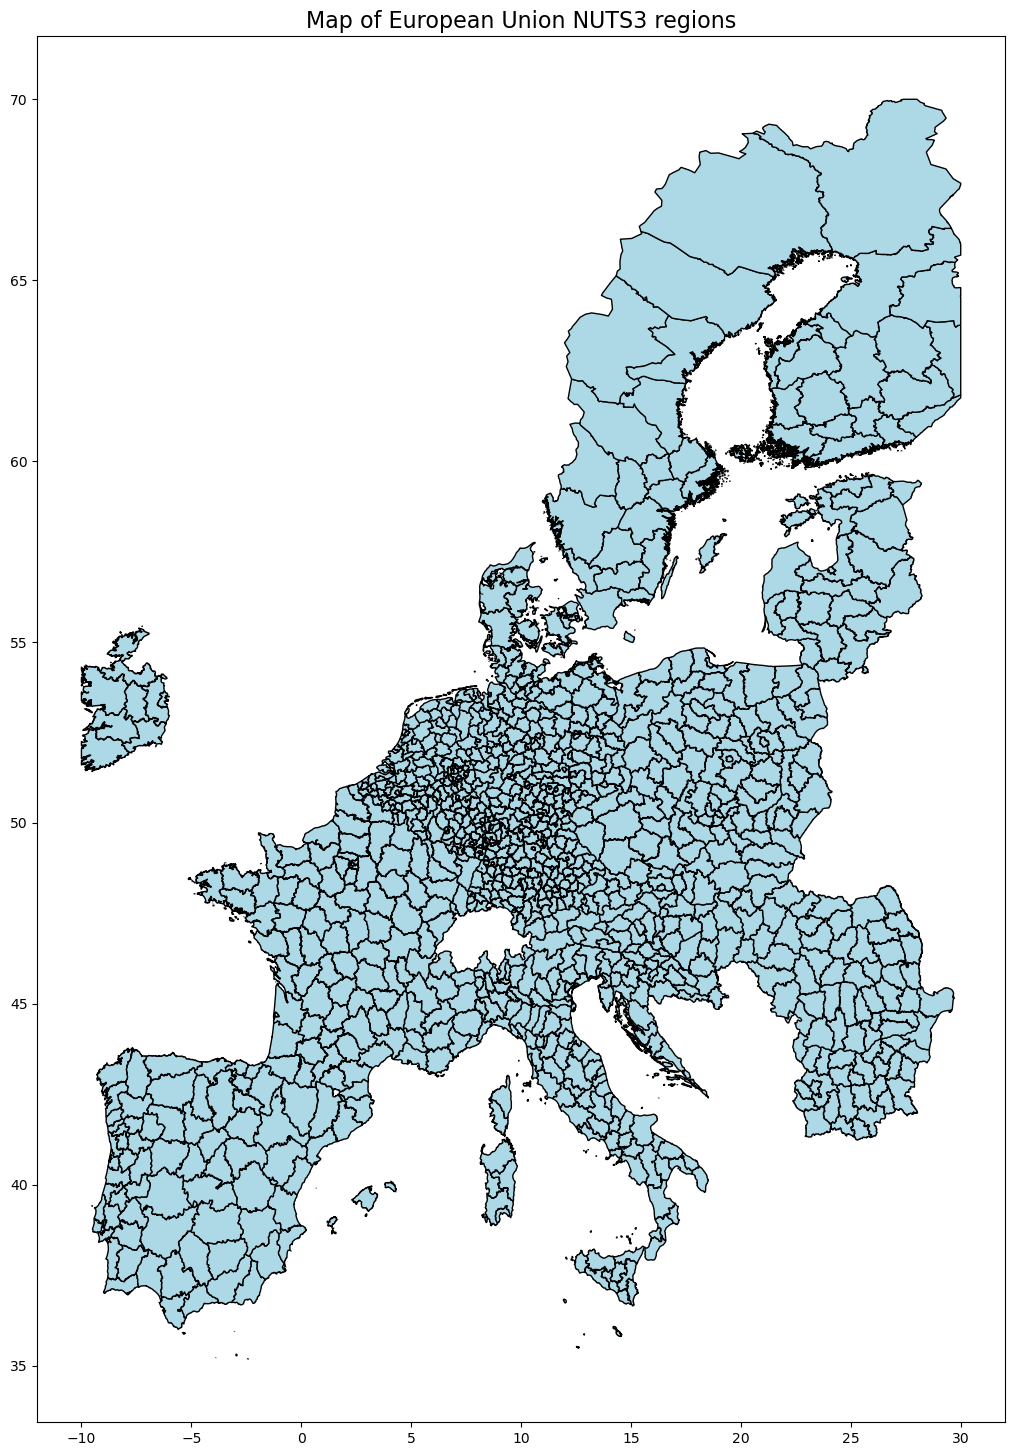

In [6]:
# Plot EU countries
fig, ax = plt.subplots(figsize=(18, 18))
eu_map.plot(ax=ax, color="lightblue", edgecolor="black")

# Add a title
ax.set_title("Map of European Union NUTS3 regions", fontsize=16)

# Show the plot
plt.show()

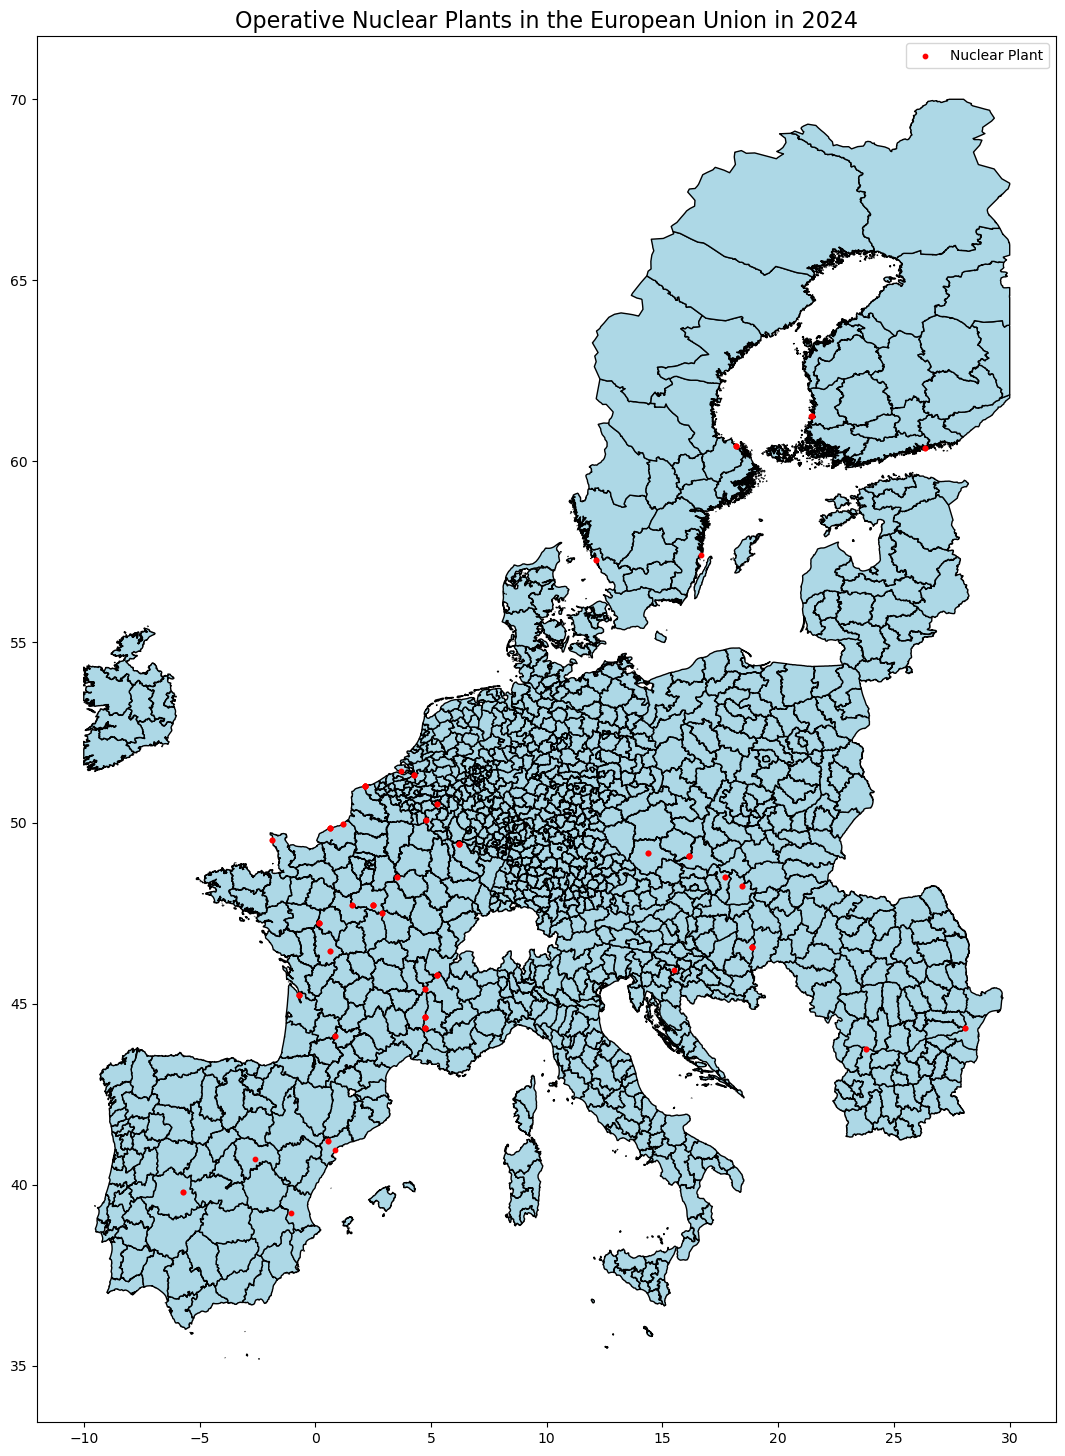

In [8]:
# Plot EU countries with nuclear plants
fig, ax = plt.subplots(figsize=(18, 18))
eu_map.plot(ax=ax, color="lightblue", edgecolor="black")
plants_gdf.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")

# Add title and legend
ax.set_title("Operative Nuclear Plants in the European Union in 2024", fontsize=16)
ax.legend()

# Save the plots
plt.savefig("nuclear_plants_eu_map.png", bbox_inches="tight")

# Show the plot
plt.show()

In [196]:
# Load GDP data
gdp = pd.read_csv("estat_nama_10r_3gdp.tsv.gz", sep="\t", compression="gzip")

# Split the combined column into separate columns
gdp_split = gdp['freq,unit,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Assign meaningful names to the new columns
gdp_split.columns = ['freq', 'unit', 'geo']

# Merge the split columns back into the original DataFrame
gdp = pd.concat([gdp, gdp_split], axis=1)

# Drop the original combined column (optional)
gdp.drop(columns=['freq,unit,geo\\TIME_PERIOD'], inplace=True)

# Step 1: Filter 'gdp' to keep only relevant rows
relevant_gdp = gdp[gdp['geo'].isin(eu_map['NUTS_ID'])]

# Step 2: Merge the filtered 'gdp' with 'eu_map'
merged = eu_map.merge(relevant_gdp, left_on="NUTS_ID", right_on="geo", how="right")

print(merged.head())
print(type(merged))

  NUTS_ID  LEVL_CODE CNTR_CODE                NAME_LATN  \
0   AT111          3        AT         Mittelburgenland   
1   AT112          3        AT           Nordburgenland   
2   AT113          3        AT            Südburgenland   
3   AT121          3        AT  Mostviertel-Eisenwurzen   
4   AT122          3        AT     Niederösterreich-Süd   

                 NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0         Mittelburgenland         4.0        3.0           3  AT111   
1           Nordburgenland         4.0        3.0           3  AT112   
2            Südburgenland         4.0        3.0           3  AT113   
3  Mostviertel-Eisenwurzen         2.0        3.0           3  AT121   
4     Niederösterreich-Süd         3.0        2.0           3  AT122   

                                            geometry  ...   2016    2017   \
0  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  ...  24500   26500    
1  POLYGON ((17.13656 47.9951, 17.09466 47.97087,...  ... 

In [216]:
years = ["2001", "2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015",
        "2016", "2017", "2018","2019","2020","2021", "2022"]  # List of year columns as strings

# Strip any leading or trailing whitespace from column names
merged.columns = merged.columns.str.strip()

# Filters the years list to include only those that exist as column names in the merged DataFrame.
years = [year for year in years if year in merged.columns]

for year in years:
    # Clean non-numeric characters and spaces
    merged[year] = merged[year].astype(str).str.strip()
    merged[year] = merged[year].str.replace(r"[^\d.]", "", regex=True)  # Keep only numbers and decimal points
    
    # Convert to numeric and fill missing values with 0 (or another default value if preferred)
    merged[year] = pd.to_numeric(merged[year], errors="coerce").fillna(0)

print(merged.dtypes)

NUTS_ID         object
LEVL_CODE        int32
CNTR_CODE       object
NAME_LATN       object
NUTS_NAME       object
MOUNT_TYPE     float64
URBN_TYPE      float64
COAST_TYPE       int32
FID             object
geometry      geometry
2000            object
2001           float64
2002           float64
2003           float64
2004           float64
2005           float64
2006           float64
2007           float64
2008           float64
2009           float64
2010           float64
2011           float64
2012           float64
2013           float64
2014           float64
2015           float64
2016           float64
2017           float64
2018           float64
2019           float64
2020           float64
2021           float64
2022           float64
freq            object
unit            object
geo             object
dtype: object


In [218]:
merged_long = pd.melt(
    merged,
    id_vars=["NUTS_ID", "geometry", "geo"],  # Keep these as identifiers
    value_vars=years,                # Only melt the year columns
    var_name="year",          # Column for years
    value_name="GDP"                 # Column for GDP values
)

# Check for missing values
print(merged_long['GDP'].isna().sum())

0


In [220]:
# Filter observations where relevant_gdp is 0
filtered_data = merged_long[merged_long['GDP'] == 0]

# Display the values of the 'geo' variable for these observations
print(filtered_data['geo'])


35        BE100
36        BE211
37        BE212
38        BE213
39        BE223
          ...  
126038    IE062
127137    IE062
128236    IE062
129335    IE062
130434    IE062
Name: geo, Length: 357, dtype: object


In [13]:
print(merged_long.dtypes)

NUTS_ID       object
geometry    geometry
geo           object
year          object
GDP          float64
dtype: object


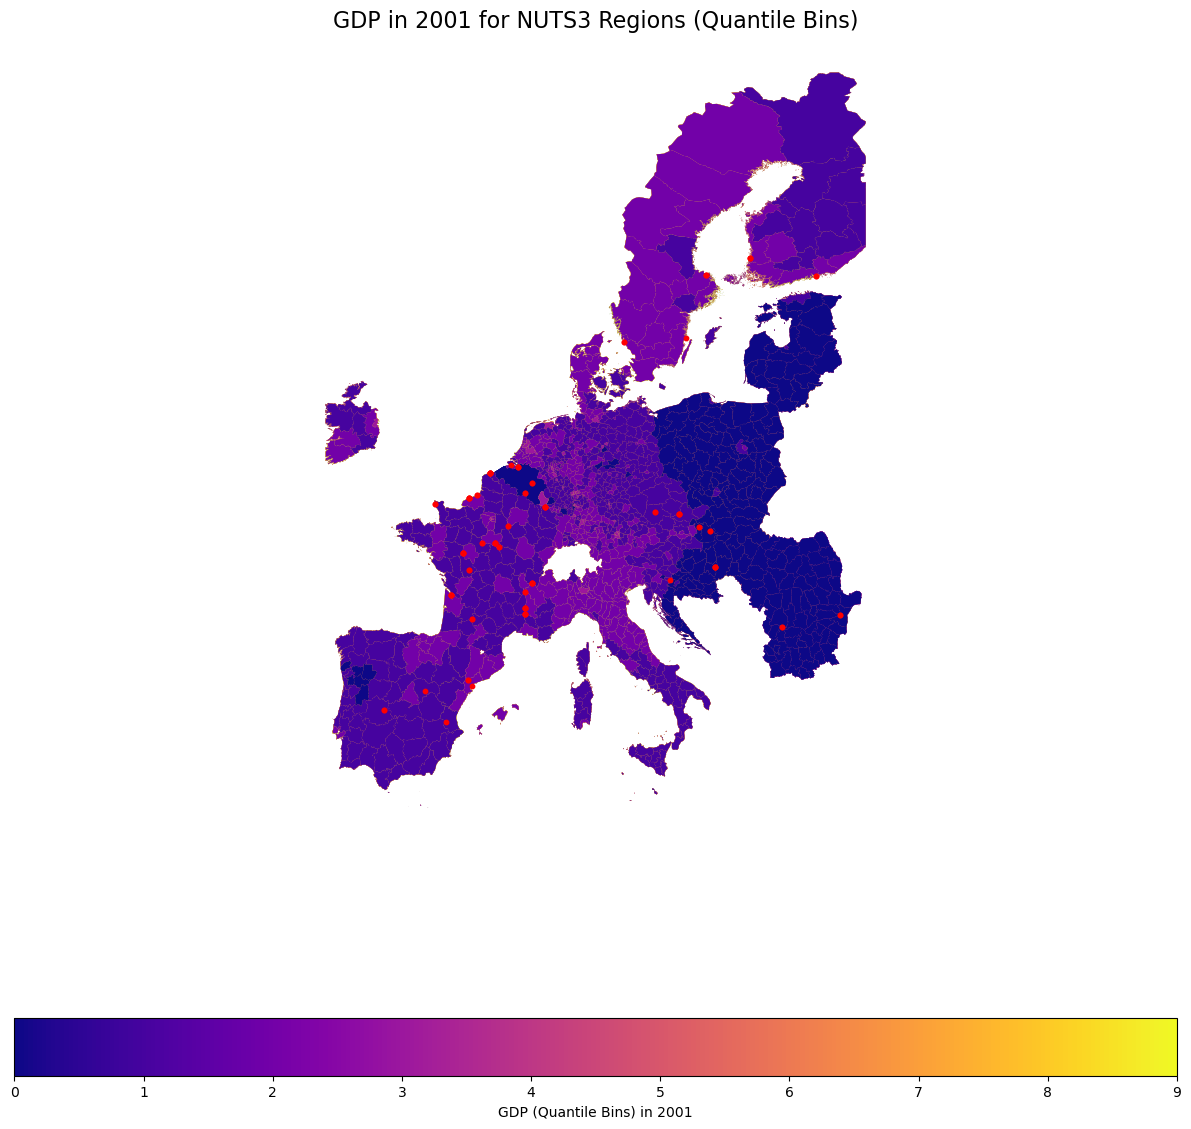

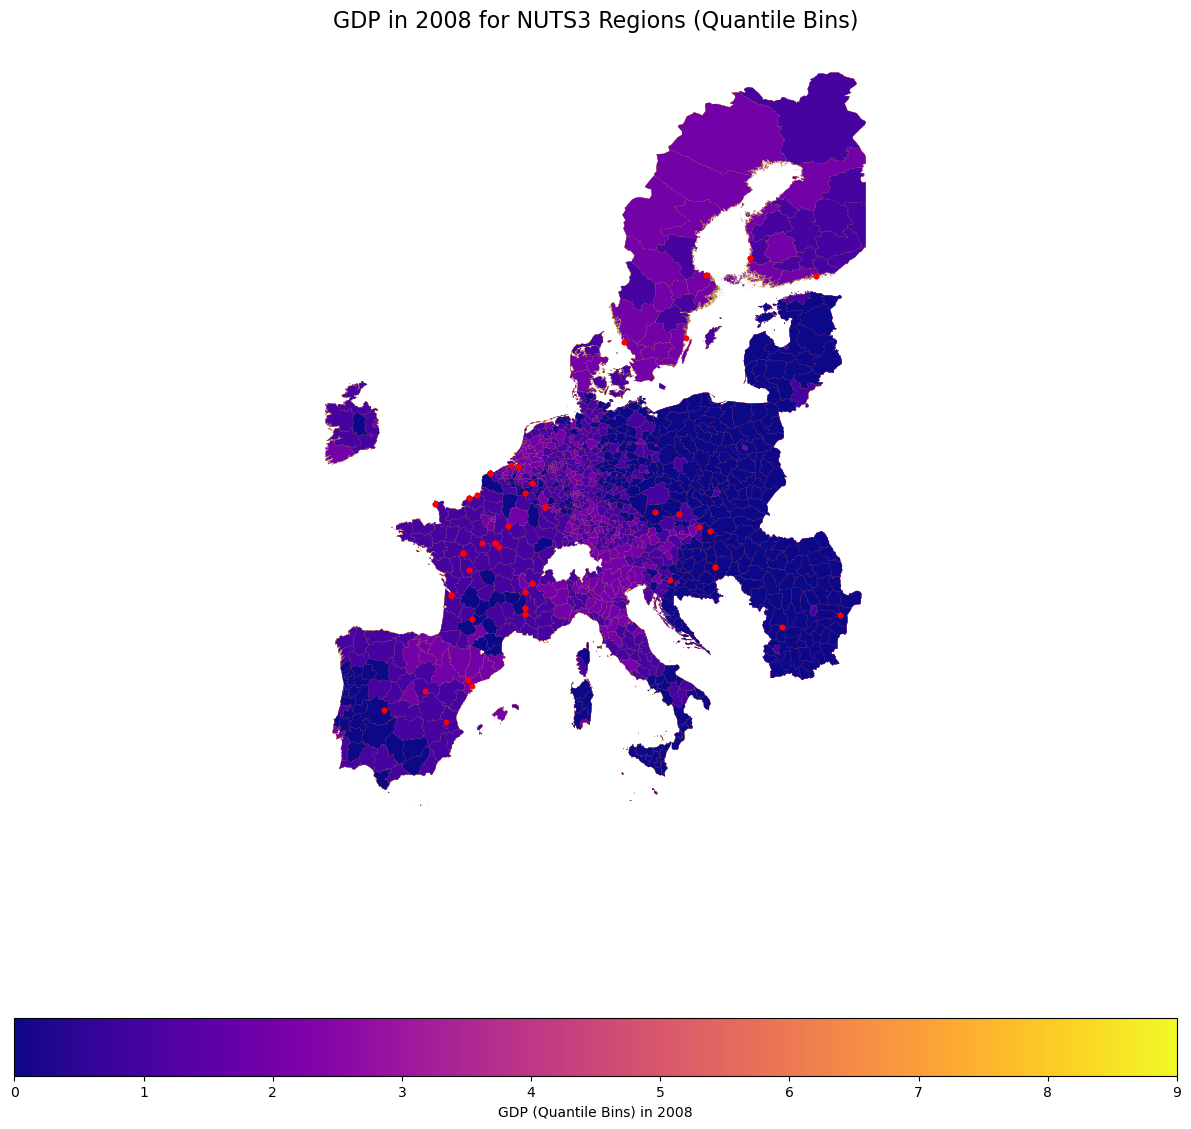

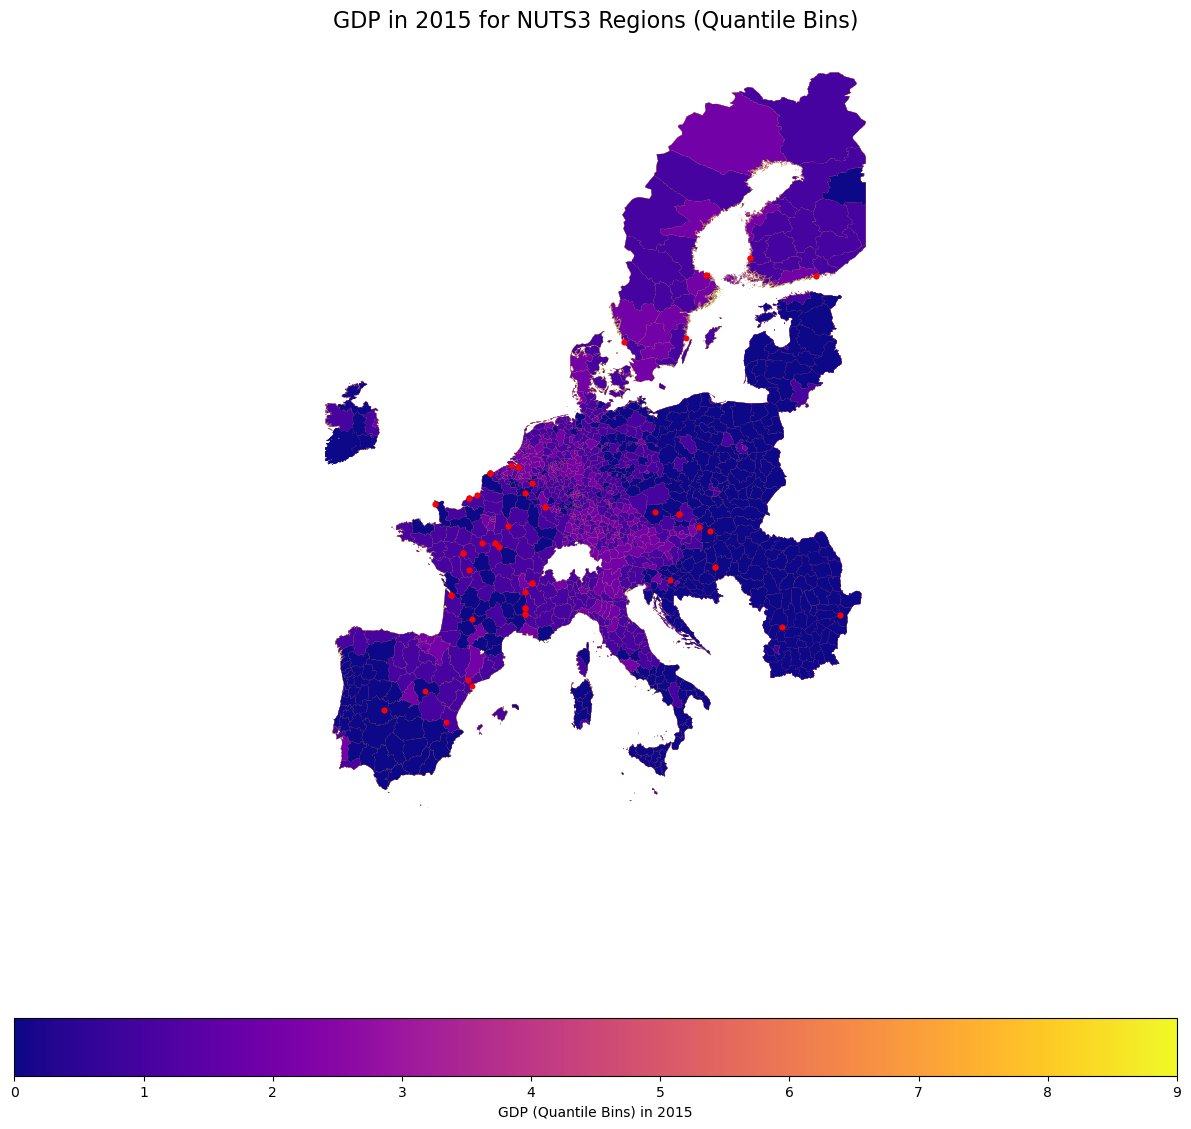

In [13]:
years_of_interest = ["2001", "2008", "2015"]
plt_merged_long = merged_long[merged_long['year'].isin(years_of_interest)]
plt_merged_long = gpd.GeoDataFrame(merged_long, geometry="geometry")

# Plot for each year
for year in years_of_interest:
    year_data = merged_long[merged_long['year'] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning
    year_data.loc[:, 'year'] = pd.to_numeric(year_data['year'], errors="coerce")  # Explicit .loc
    year_data.loc[:, "Log_GDP"] = np.log1p(year_data["GDP"])  # Explicit .loc
    # Normalize GDP values to the range 0–1
    year_data["Scaled_GDP"] = (year_data["GDP"] - year_data["GDP"].min()) / (year_data["GDP"].max() - year_data["GDP"].min())
    # Add a new column with quantile bins
    year_data["GDP_Bins"] = pd.qcut(year_data["GDP"], q=10, labels=False)
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    year_data.plot(
    column="GDP_Bins",
    cmap="plasma",
    legend=True,
    ax=ax,
    legend_kwds={
        "label": f"GDP (Quantile Bins) in {year}",
        "orientation": "horizontal"
    }
)
    plants_gdf.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
    ax.set_title(f"GDP in {year} for NUTS3 Regions (Quantile Bins)", fontsize=16)
    ax.axis("off")
    plt.savefig(f"GDPs_for_NUTS3_Provinces_{year}.png", bbox_inches="tight") # Save the plot
    plt.show() # Show the plot
    

We now plot GDP for France

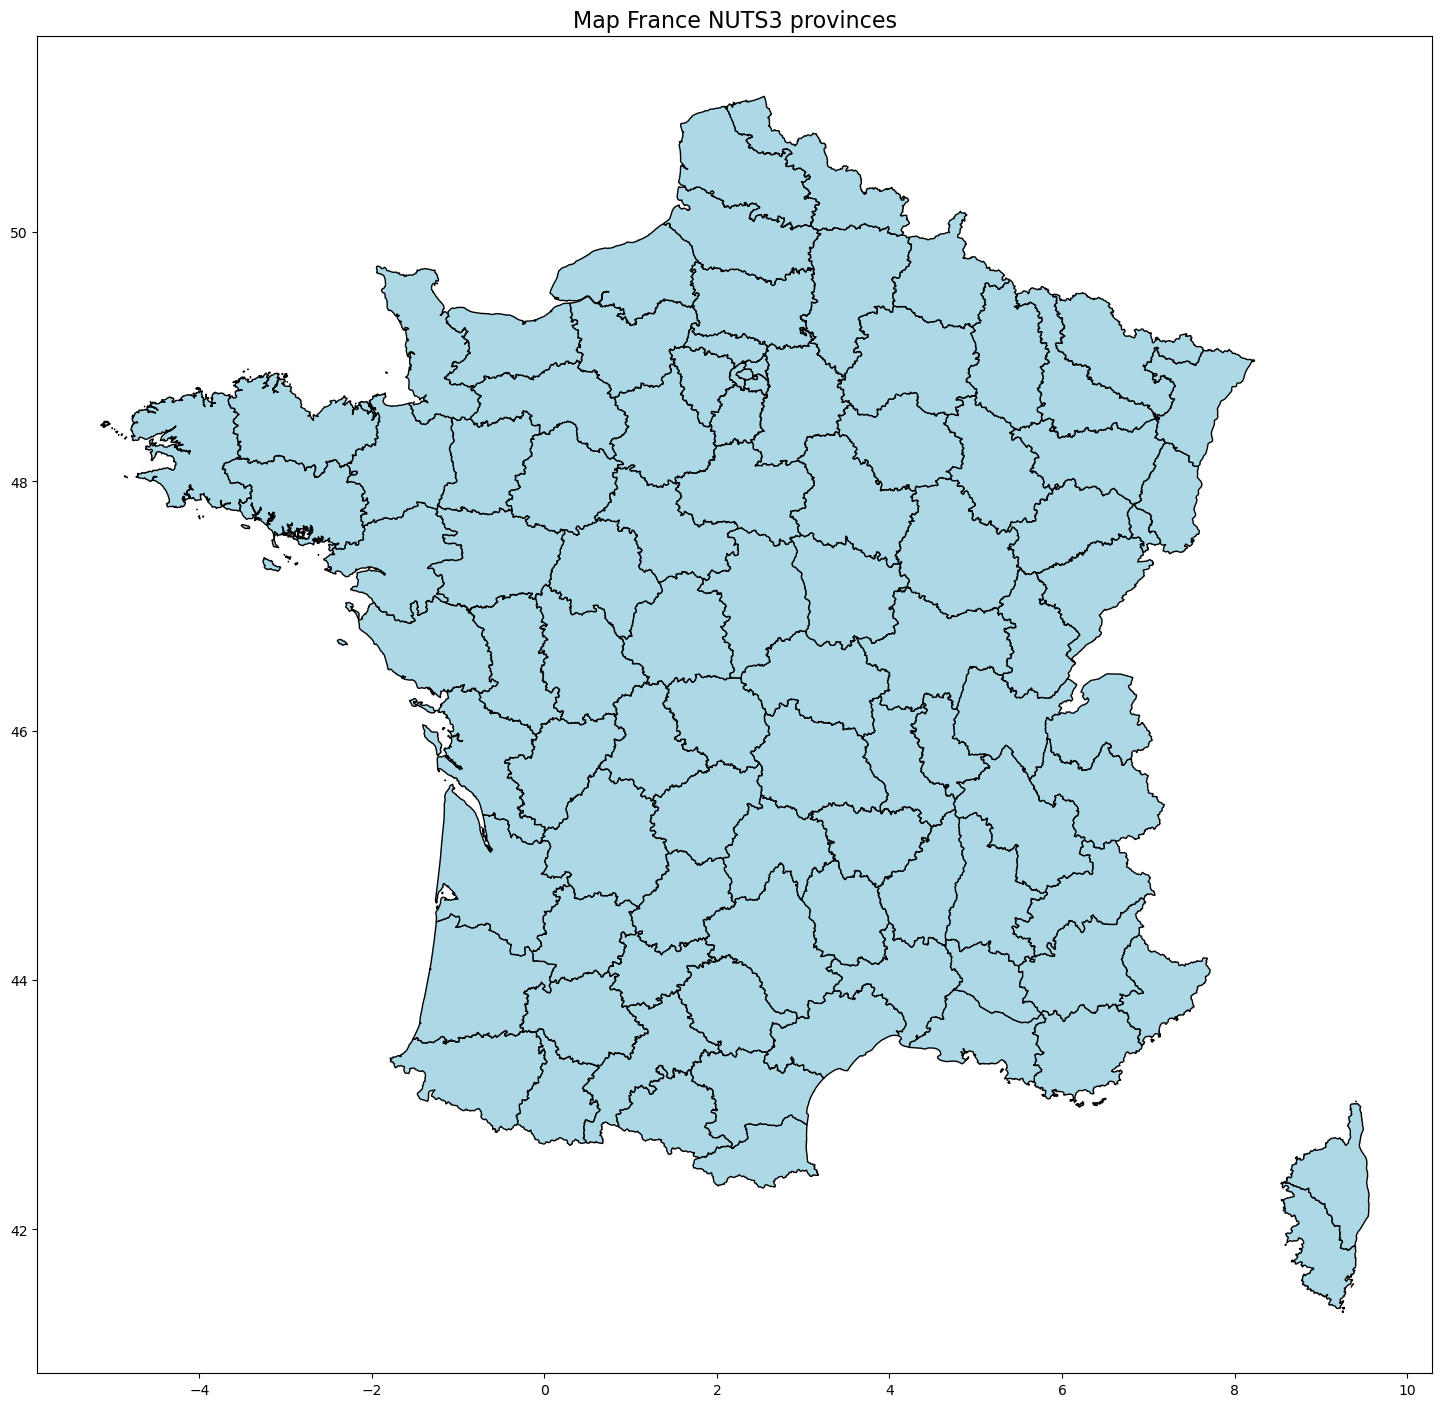

In [15]:
eu_iso2_codes_FRonly = ["FR"]

# Filter Nuclear Plants dataset and the shapefile for France
nuclear_plants_FRonly = nuclear_plants[nuclear_plants['CountryCode'].isin(eu_iso2_codes_FRonly)]
eu_map_FRonly = eu_map[eu_map['CNTR_CODE'].isin(eu_iso2_codes_FRonly)]

# Create a bounding box as a shapely object
bounding_polygon_FRonly = box(bounding_box["minx"], bounding_box["miny"], bounding_box["maxx"], bounding_box["maxy"])

# Clip the map using the bounding box
eu_map_FRonly = eu_map_FRonly.clip(bounding_polygon_FRonly)
fig, ax = plt.subplots(figsize=(18, 18))
eu_map_FRonly.plot(ax=ax, color="lightblue", edgecolor="black")
ax.set_title("Map France NUTS3 provinces", fontsize=16) # Add a title

# Show the plot
plt.show()

EPSG:4326


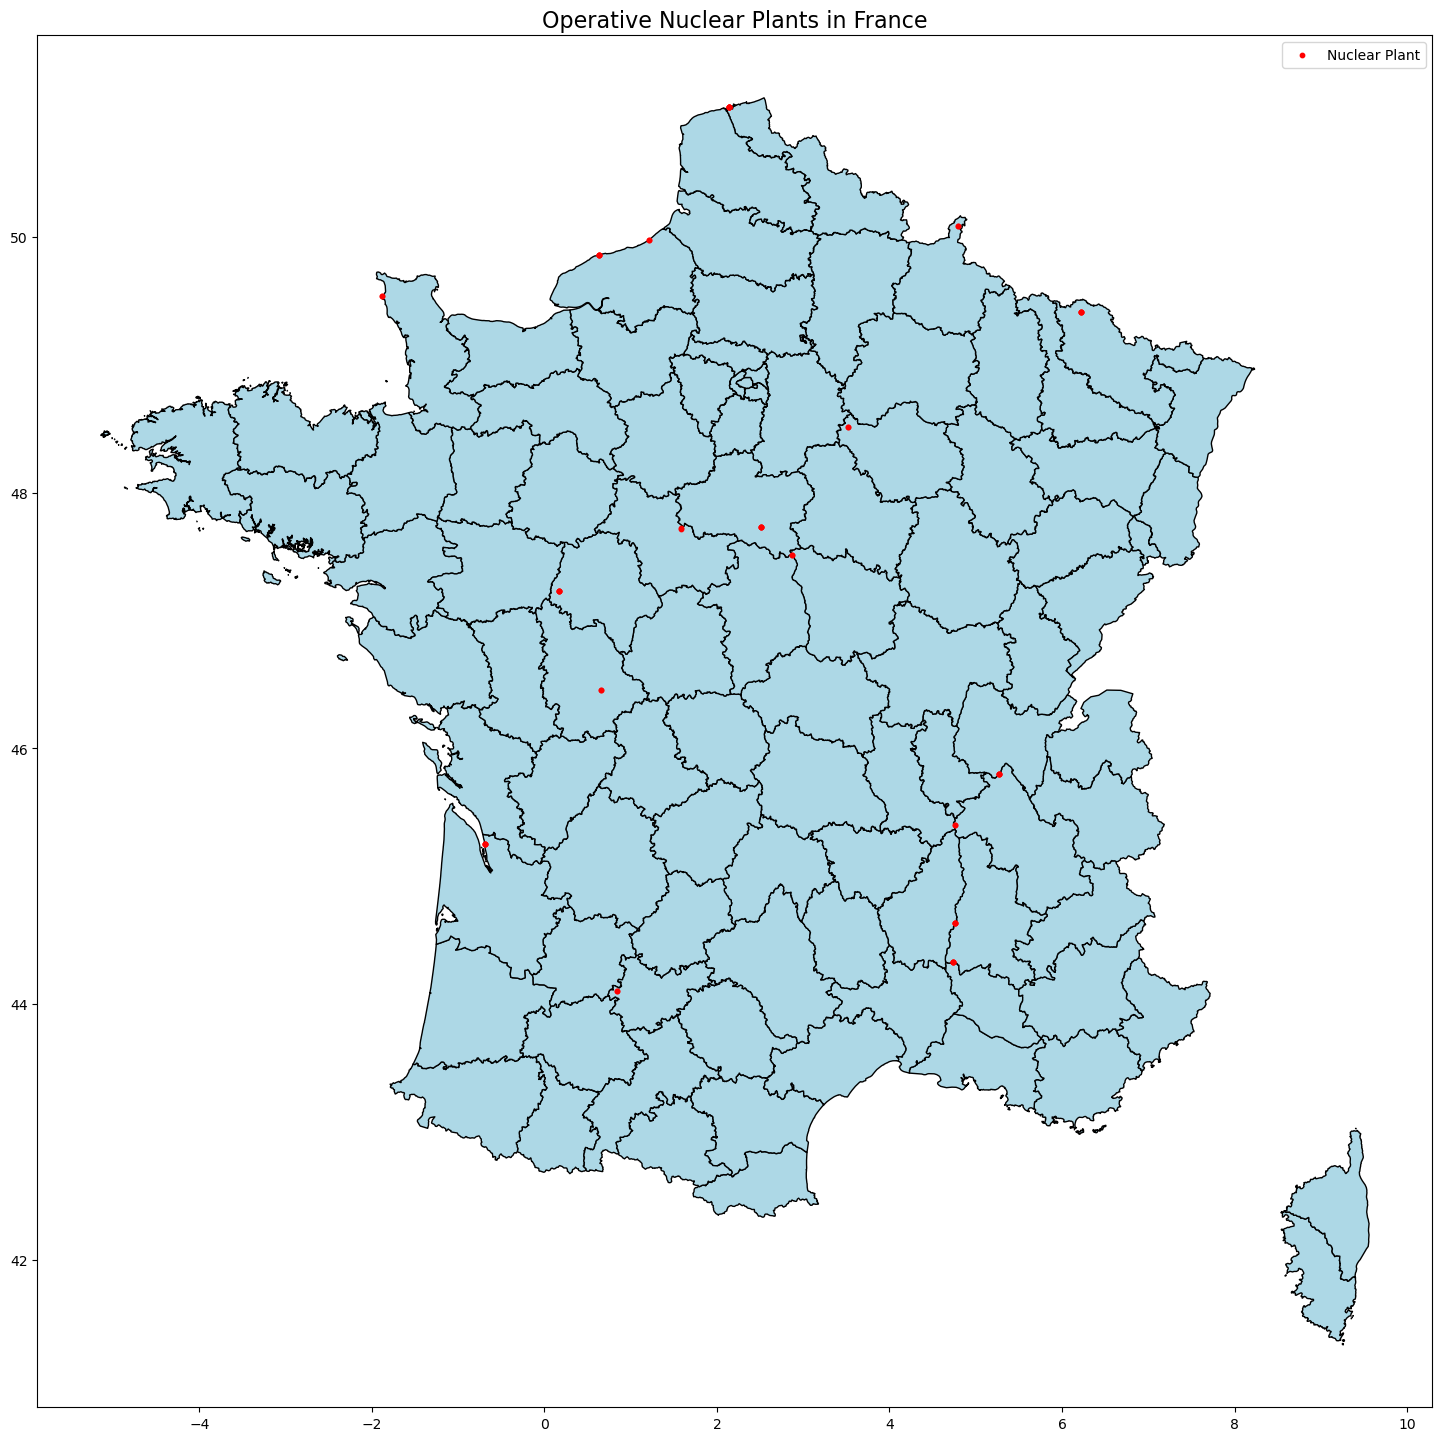

In [16]:
# Create a GeoDataFrame for nuclear plants
plants_gdf = gpd.GeoDataFrame(
    nuclear_plants_FRonly, geometry=gpd.points_from_xy(nuclear_plants_FRonly.Longitude, nuclear_plants_FRonly.Latitude), crs="EPSG:4326"
)
print(plants_gdf.crs)

fig, ax = plt.subplots(figsize=(18, 18))
eu_map_FRonly.plot(ax=ax, color="lightblue", edgecolor="black")
plants_gdf.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
ax.set_title("Operative Nuclear Plants in France", fontsize=16) # Add title and legend
ax.legend()
# Show the plot
plt.show()

In [17]:
gdp_pc = pd.read_csv("estat_nama_10r_3gdp.tsv.gz", sep="\t", compression="gzip") # GDP per capita regional

print(gdp_pc)

       freq,unit,geo\TIME_PERIOD 2000  2001  2002  2003  2004  2005  2006   \
0                   A,EUR_HAB,AL    :     :     :     :     :     :     :    
1                  A,EUR_HAB,AL0    :     :     :     :     :     :     :    
2                 A,EUR_HAB,AL01    :     :     :     :     :     :     :    
3                A,EUR_HAB,AL011    :     :     :     :     :     :     :    
4                A,EUR_HAB,AL012    :     :     :     :     :     :     :    
...                          ...   ...   ...   ...   ...   ...   ...   ...   
12448   A,PPS_HAB_EU27_2020,TRC3    :     :     :     :    18    19    20    
12449  A,PPS_HAB_EU27_2020,TRC31    :     :     :     :    16    17    18    
12450  A,PPS_HAB_EU27_2020,TRC32    :     :     :     :    19    21    22    
12451  A,PPS_HAB_EU27_2020,TRC33    :     :     :     :    19    19    20    
12452  A,PPS_HAB_EU27_2020,TRC34    :     :     :     :    17    19    20    

      2007   2008   ...  2013    2014   2015   2016   2017   20

In [18]:
# Split the combined column into separate columns
gdp_split = gdp_pc['freq,unit,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Assign meaningful names to the new columns
gdp_split.columns = ['freq', 'unit', 'geo']

# Merge the split columns back into the original DataFrame
gdp_pc = pd.concat([gdp_pc, gdp_split], axis=1)

# Drop the original combined column (optional)
gdp_pc.drop(columns=['freq,unit,geo\\TIME_PERIOD'], inplace=True)

# Filter the dataset to include only rows where "geo" starts with an allowed prefix
gdp_filtered_FRonly = gdp_pc[gdp_pc['geo'].str[:2].isin(eu_iso2_codes_FRonly )]

print(gdp_filtered_FRonly)

        2000    2001    2002    2003    2004    2005    2006    2007    2008   \
890    24300   25100   25700   26200   27200   28000   29100   30300   31000    
891    39200   40300   41500   42000   43100   44600   46000   48700   50200    
892    39200   40300   41500   42000   43100   44600   46000   48700   50200    
893    72300   74700   75000   75000   76200   78800   79800   84500   84800    
894    20400   20200   21800   22300   23300   23500   24700   25900   27300    
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
11723     57      62      62      55      54      54      53      50      49    
11724     64      66      67      67      67      69      69      68      68    
11725     64      66      67      67      67      69      69      68      68    
11726     18      18      18      19      20      21      22      22      24    
11727     18      18      18      19      20      21      22      22      24    

        2009   ...    2016 

In [19]:
nuts_ids = set(eu_map_FRonly["NUTS_ID"].unique())
geo_codes = set(gdp_filtered_FRonly["geo"].unique())

# Find common values
common_codes = nuts_ids.intersection(geo_codes)

# Find missing values
nuts_not_in_geo = nuts_ids.difference(geo_codes)  # In NUTS_ID but not in geo
geo_not_in_nuts = geo_codes.difference(nuts_ids)  # In geo but not in NUTS_ID

# Print results
print(f"Number of common codes: {len(common_codes)}")
print(f"Codes in NUTS_ID but not in geo: {nuts_not_in_geo}")
print(f"Codes in geo but not in NUTS_ID: {geo_not_in_nuts}")

Number of common codes: 96
Codes in NUTS_ID but not in geo: set()
Codes in geo but not in NUTS_ID: {'FRH0', 'FR', 'FRF1', 'FR1', 'FRH', 'FRK1', 'FRF2', 'FRB0', 'FRE2', 'FRY30', 'FRY50', 'FRI1', 'FRD2', 'FRF', 'FRC1', 'FRJ', 'FRB', 'FRM0', 'FRY4', 'FRE', 'FRC2', 'FRL0', 'FRJ2', 'FRK', 'FRD1', 'FRZZZ', 'FRZZ', 'FRJ1', 'FRK2', 'FRY3', 'FRY', 'FRY2', 'FRZ', 'FRI2', 'FRE1', 'FRY20', 'FRY5', 'FRL', 'FRY10', 'FRI3', 'FR10', 'FRM', 'FRG0', 'FRY40', 'FRI', 'FRF3', 'FRC', 'FRD', 'FRY1', 'FRG'}


In [20]:
# Step 1: Filter 'gdp' to keep only relevant rows
relevant_gdp = gdp_pc[gdp_pc['geo'].isin(eu_map_FRonly['NUTS_ID'])]

# Step 2: Merge the filtered 'gdp' with 'eu_map'
merged = eu_map_FRonly.merge(relevant_gdp, left_on="NUTS_ID", right_on="geo", how="left")

print(relevant_gdp)
print(merged)

        2000    2001    2002    2003    2004    2005    2006    2007    2008   \
893    72300   74700   75000   75000   76200   78800   79800   84500   84800    
894    20400   20200   21800   22300   23300   23500   24700   25900   27300    
895    29100   30000   30600   30900   31400   32600   33500   35500   37400    
896    26300   27600   28800   29900   30600   30100   31800   33600   36200    
897    66200   67900   70800   71200   73500   77600   79700   84900   88800    
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
11710    112     113     111     108     109     111     110     106     107    
11711     91      92      93      91      90      92      90      88      80    
11712     99      99     101      97      95      96      94      92      94    
11715     97     100      98      95      94      96      95      91      92    
11716     77      77      75      74      72      75      74      70      76    

        2009   ...    2016 

In [21]:
years = ["2001", "2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015",
        "2016", "2017", "2018","2019","2020","2021","2022",]  # List of year columns as strings

# Strip any leading or trailing whitespace from column names
merged.columns = merged.columns.str.strip()

# Loop through each year in the list and convert the column to numeric
years = [year for year in years if year in merged.columns]

for year in years:
    merged[year] = pd.to_numeric(merged[year], errors="coerce")

FR_merged_long = pd.melt(
    merged,
    id_vars=["NUTS_ID", "geo", "geometry"],  # Keep these as identifiers
    value_vars=years,                # Only melt the year columns
    var_name="year",          # Column for years
    value_name="GDP"                 # Column for GDP values
)

years_of_interest = ["2001", "2002", "2003", "2004", "2005"]
FR_merged_long = FR_merged_long[FR_merged_long["year"].isin(years_of_interest)]
FR_merged_long = gpd.GeoDataFrame(FR_merged_long, geometry="geometry")


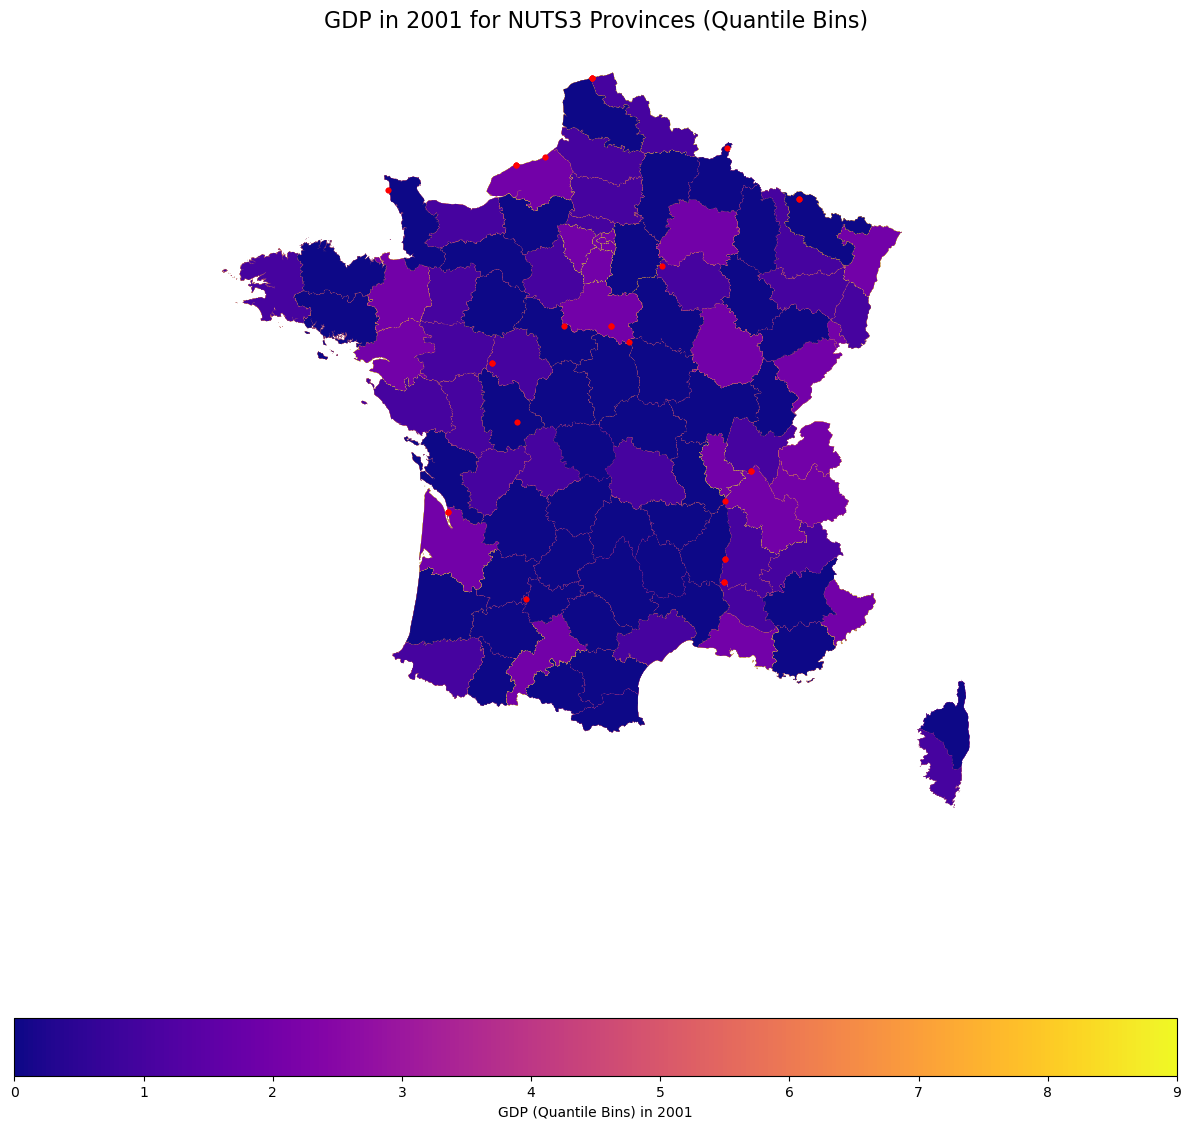

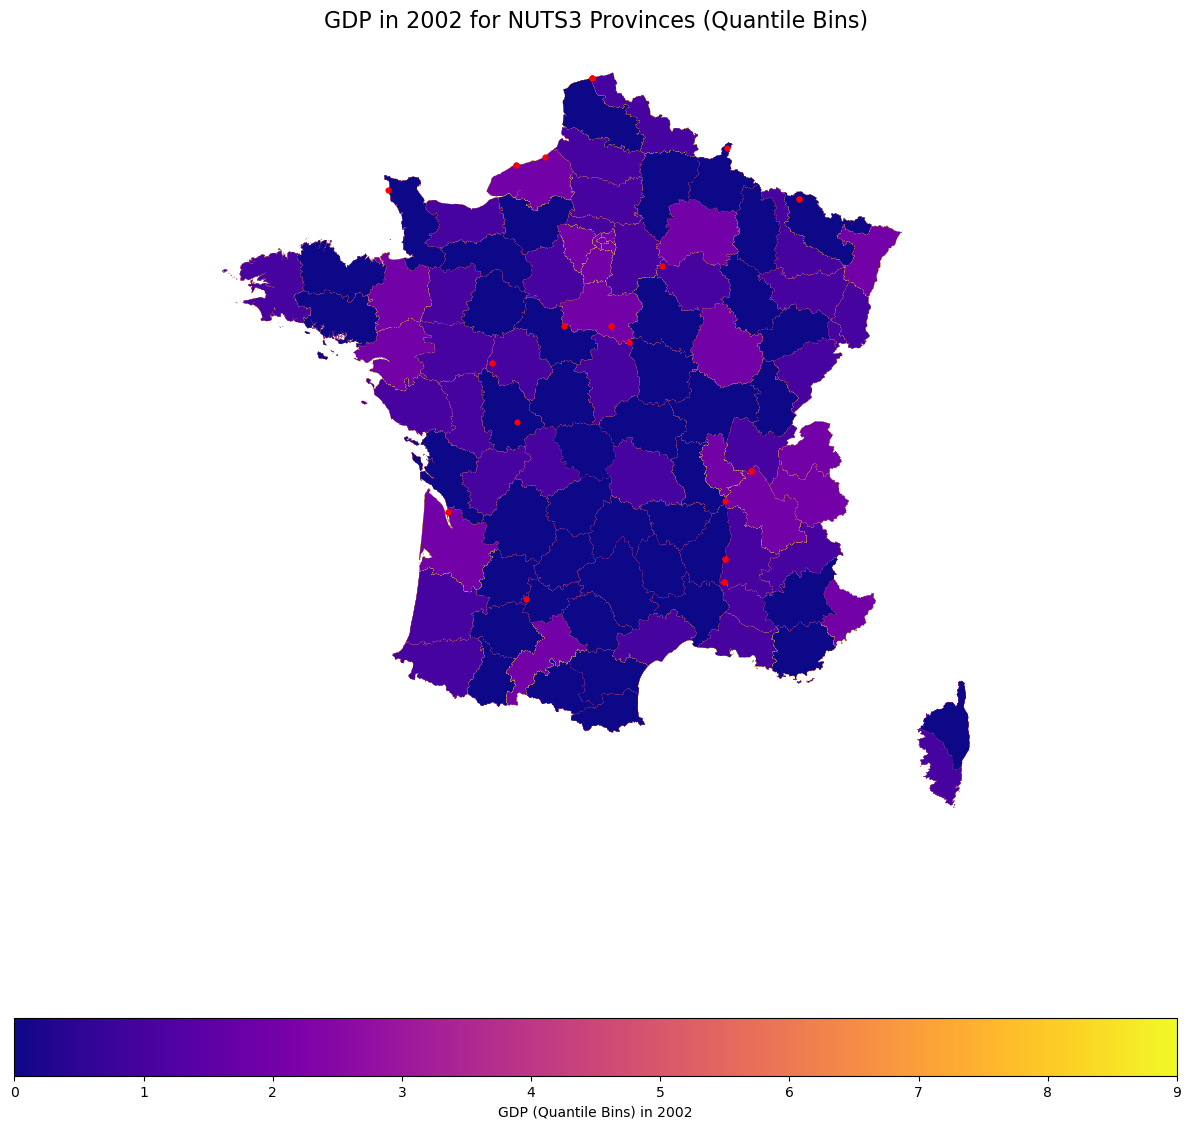

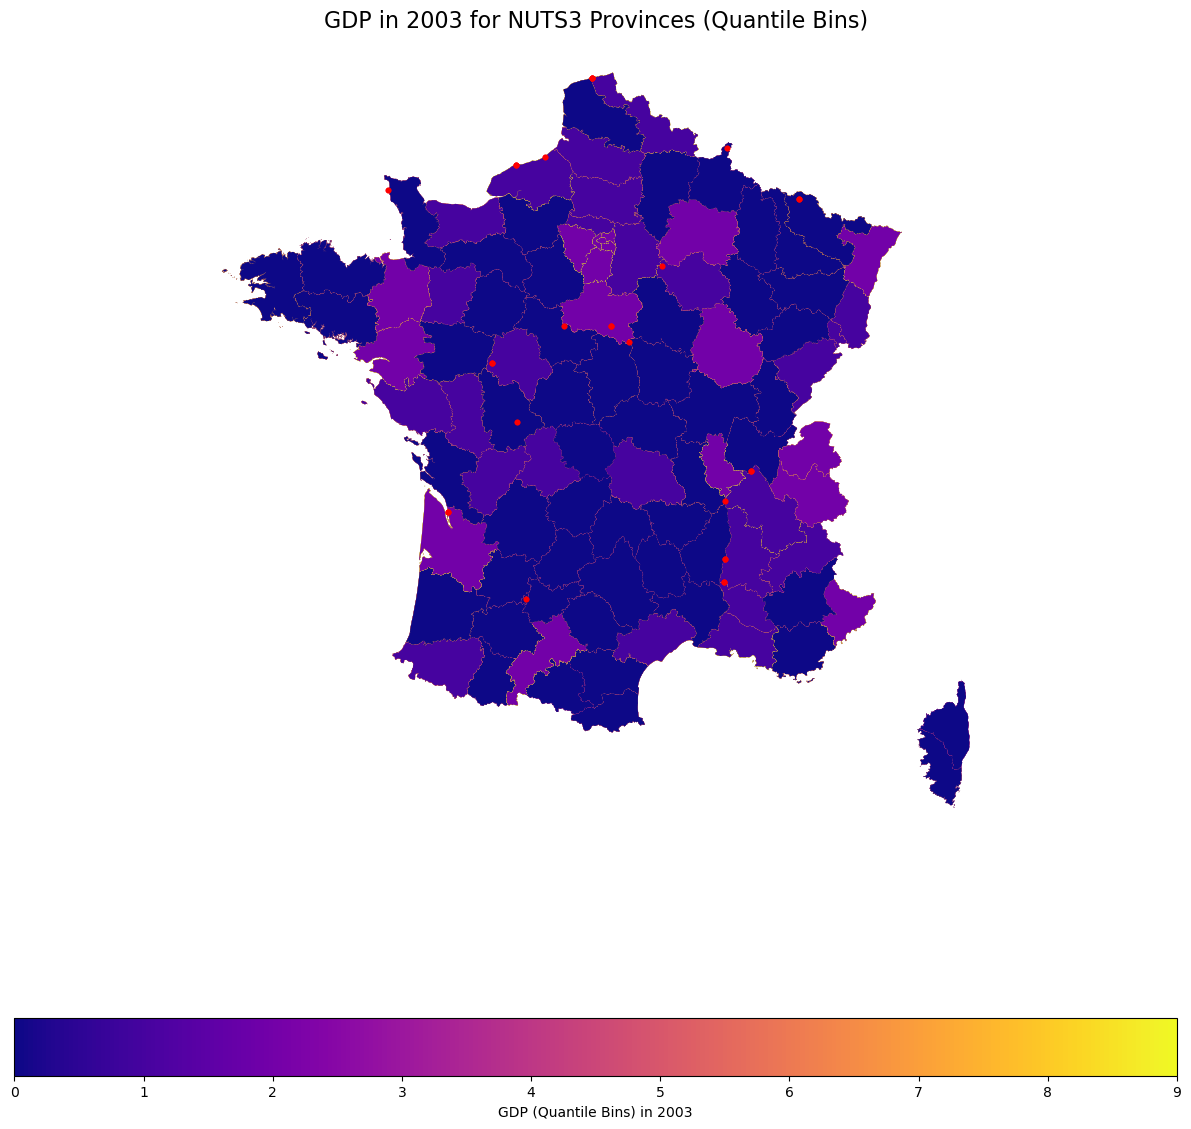

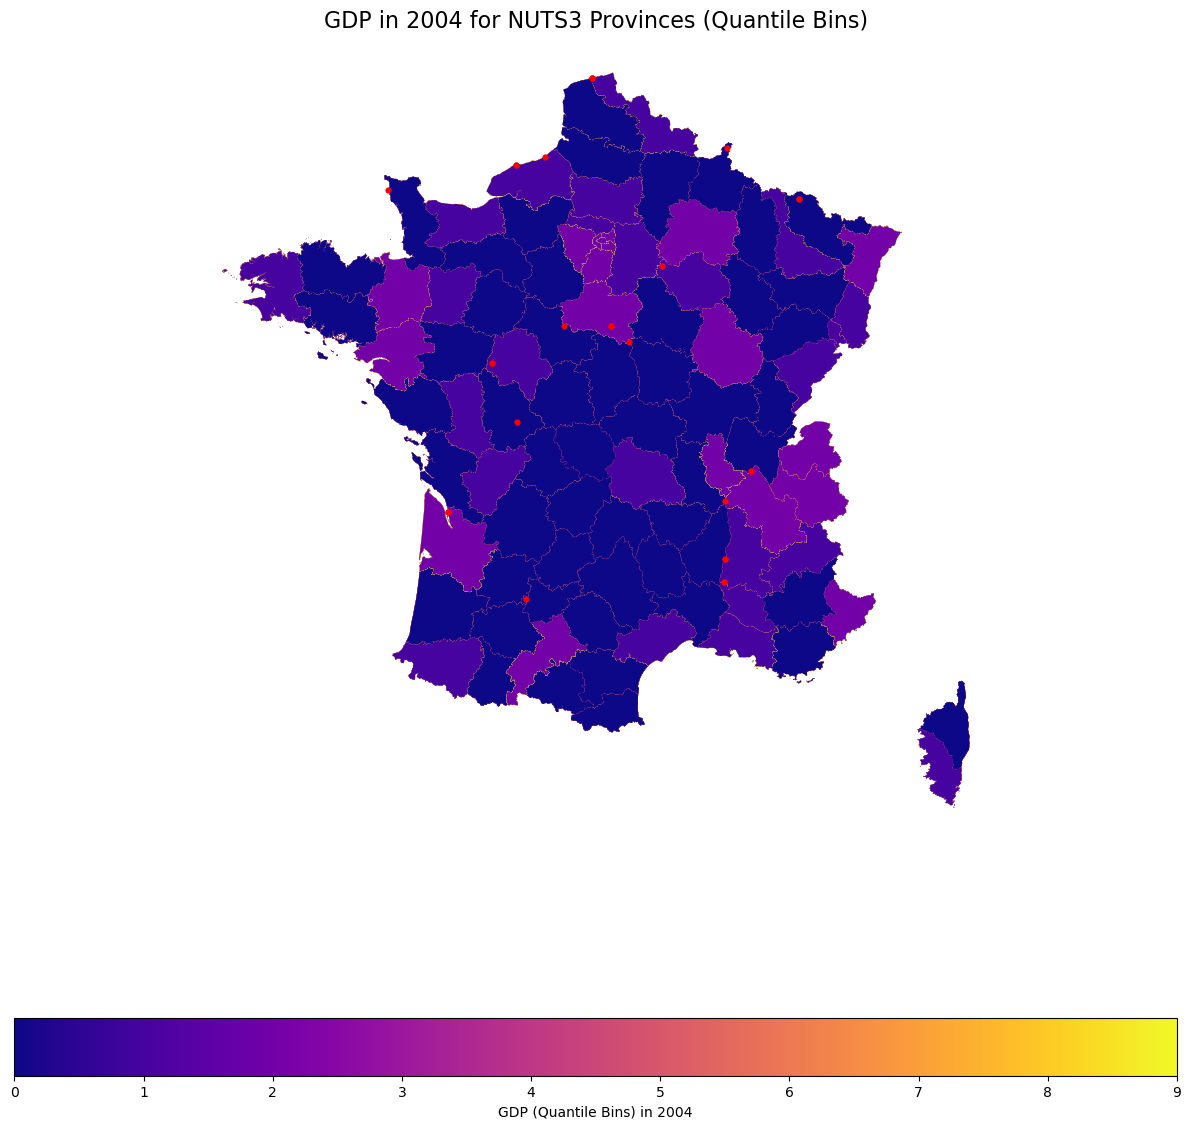

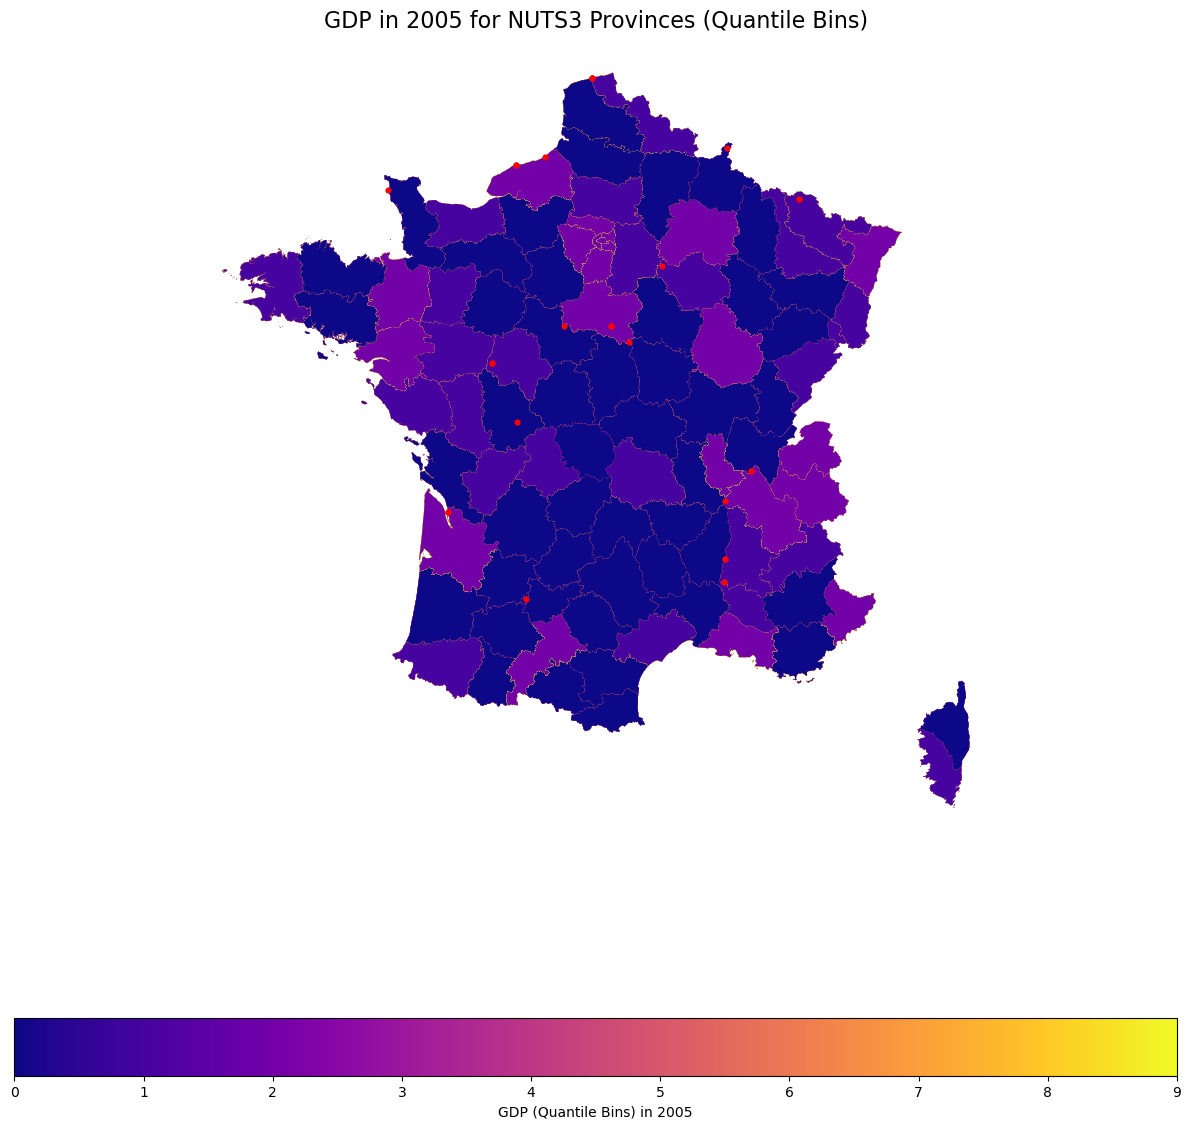

In [22]:
# Plot for each year
for year in years_of_interest:
    year_data = FR_merged_long[FR_merged_long["year"] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning
    year_data.loc[:, "year"] = pd.to_numeric(year_data["year"], errors="coerce")  # Explicit .loc
    year_data.loc[:, "Log_GDP"] = np.log1p(year_data["GDP"])  # Explicit .loc
    # Normalize GDP values to the range 0–1
    year_data["Scaled_GDP"] = (year_data["GDP"] - year_data["GDP"].min()) / (year_data["GDP"].max() - year_data["GDP"].min())
    # Add a new column with quantile bins
    year_data["GDP_Bins"] = pd.qcut(year_data["GDP"], q=10, labels=False)
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    year_data.plot(
    column="GDP_Bins",
    cmap="plasma",
    legend=True,
    ax=ax,
    legend_kwds={
        "label": f"GDP (Quantile Bins) in {year}",
        "orientation": "horizontal"
    }
)
    plants_gdf.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
    ax.set_title(f"GDP in {year} for NUTS3 Provinces (Quantile Bins)", fontsize=16)
    ax.axis("off")
    plt.show()

We now use FE method to analyse whether there is a correlation between the presence of Nuclear Plants and GDB and other economic variables. The analysis will be performed locally, that is, withing NUTS3 regions of EU.
First, we create a dateset for the analysis. We "fix" up the "nuclear_plants" dataset before merging it with "merged_long":

In [138]:
# Create a function to check operational status
def is_operational(row, year):
    return (row['OperationalFrom'].year <= year) and (pd.isnull(row['OperationalTo']) or row['OperationalTo'].year >= year)

# Generalize: Create a binary variable for each year in the GDP dataset
years = range(2001, 2022)  # Adjust the range based on your GDP dataset
for year in years:
    plants_gdf[f'is_operational_{year}'] = plants_gdf.apply(lambda row: is_operational(row, year), axis=1)
 
print(plants_gdf.columns)


Index(['Id', 'Name', 'Latitude', 'Longitude', 'Country', 'CountryCode',
       'Status', 'ReactorType', 'ReactorModel', 'ConstructionStartAt',
       'OperationalFrom', 'OperationalTo', 'Capacity', 'LastUpdatedAt',
       'Source', 'IAEAId', 'geometry', 'is_operational_2001',
       'is_operational_2002', 'is_operational_2003', 'is_operational_2004',
       'is_operational_2005', 'is_operational_2006', 'is_operational_2007',
       'is_operational_2008', 'is_operational_2009', 'is_operational_2010',
       'is_operational_2011', 'is_operational_2012', 'is_operational_2013',
       'is_operational_2014', 'is_operational_2015', 'is_operational_2016',
       'is_operational_2017', 'is_operational_2018', 'is_operational_2019',
       'is_operational_2020', 'is_operational_2021'],
      dtype='object')


In [29]:
# Perform spatial join to map nuclear plants to NUTS3 regions
new_nuclear_plants = gpd.sjoin(plants_gdf, eu_map, how="left", predicate="within")

new_nuclear_plants.head()

Id          Name  Latitude  Longitude Country CountryCode       Status  \
10  11     Almaraz-1    39.807     -5.698   Spain          ES  Operational   
11  12     Almaraz-2    39.807     -5.698   Spain          ES  Operational   
21  22        Asco-1    41.202      0.571   Spain          ES  Operational   
22  23        Asco-2    41.202      0.571   Spain          ES  Operational   
43  44  Belleville-1    47.511      2.871  France          FR  Operational   

   ReactorType ReactorModel ConstructionStartAt  ... index_right NUTS_ID  \
10         PWR       WH 3LP          1973-07-03  ...       461.0   ES432   
11         PWR       WH 3LP          1973-07-03  ...       461.0   ES432   
21         PWR       WH 3LP          1974-05-16  ...       348.0   ES514   
22         PWR       WH 3LP          1975-03-07  ...       348.0   ES514   
43         PWR  P4 REP 1300          1980-05-01  ...       884.0   FRB01   

    LEVL_CODE CNTR_CODE  NAME_LATN  NUTS_NAME MOUNT_TYPE  URBN_TYPE  \
10        3.0        ES    Cáceres    Cáceres        4.0        2.0   
11        3.0        ES    Cáceres    Cáceres        4.0        2.0   
21        3.0        ES  Tarragona  Tarragona        2.0        2.0   
22        3.0        ES  Tarragona  Tarragona        2.0        2.0   
43        3.0        FR       Cher       Cher        4.0        3.0   

    COAST_TYPE    FID  
10         3.0  ES432  
11         3.0  ES432  
21         1.0  ES514  
22         1.0  ES514  
43         3.0  FRB01  

[5 rows x 48 columns]

In [31]:
# Reshape the operational data to long format for merging
operational_long = new_nuclear_plants.melt(
    id_vars=['NUTS_ID'],  # Replace with the column identifying the region
    value_vars=[f'is_operational_{year}' for year in years],
    var_name='year',
    value_name='plant_operational'
)

# Extract year as an integer from the column name
operational_long['year'] = operational_long['year'].str.extract(r'(\d+)').astype(int)

# Convert the 'year' column to integers in both DataFrames
merged_long['year'] = merged_long['year'].astype(int)

# Merge with the GDP dataset
merged_long = pd.merge(merged_long, operational_long, on=['NUTS_ID', 'year'], how='left')

# Fill missing values in the plant_operational column with 0 (no plant in operation)
merged_long['plant_operational'] = merged_long['plant_operational'].fillna(0).astype(int)

merged_long.head()

NUTS_ID                                           geometry    geo  year  \
0   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111  2001   
1   AT112  POLYGON ((17.13656 47.9951, 17.09466 47.97087,...  AT112  2001   
2   AT113  POLYGON ((16.44414 47.34632, 16.44847 47.33988...  AT113  2001   
3   AT121  POLYGON ((15.51229 48.3102, 15.52049 48.31099,...  AT121  2001   
4   AT122  POLYGON ((15.93363 48.07037, 15.94567 48.06833...  AT122  2001   

       GDP  plant_operational  
0  16500.0                  0  
1  19600.0                  0  
2  16200.0                  0  
3  20900.0                  0  
4  19600.0                  0

Add Macroeconomic Control Variables, like population, employment , or investments

In [34]:
# Load population by NUTS3 
pop = pd.read_csv("estat_demo_r_pjanaggr3.tsv.gz", sep="\t", compression="gzip")

# Load employment by NUTS3 
emp = pd.read_csv("estat_nama_10r_3empers.tsv.gz", sep="\t", compression="gzip")

# Load population growth rates by NUTS3 
pop_growth = pd.read_csv("estat_demo_r_gind3.tsv.gz", sep="\t", compression="gzip")

print(pop.columns)
print(emp.columns)
pop.head()

Index(['freq,unit,sex,age,geo\TIME_PERIOD', '1990 ', '1991 ', '1992 ', '1993 ',
       '1994 ', '1995 ', '1996 ', '1997 ', '1998 ', '1999 ', '2000 ', '2001 ',
       '2002 ', '2003 ', '2004 ', '2005 ', '2006 ', '2007 ', '2008 ', '2009 ',
       '2010 ', '2011 ', '2012 ', '2013 ', '2014 ', '2015 ', '2016 ', '2017 ',
       '2018 ', '2019 ', '2020 ', '2021 ', '2022 ', '2023 '],
      dtype='object')
Index(['freq,unit,wstatus,nace_r2,geo\TIME_PERIOD', '1995 ', '1996 ', '1997 ',
       '1998 ', '1999 ', '2000 ', '2001 ', '2002 ', '2003 ', '2004 ', '2005 ',
       '2006 ', '2007 ', '2008 ', '2009 ', '2010 ', '2011 ', '2012 ', '2013 ',
       '2014 ', '2015 ', '2016 ', '2017 ', '2018 ', '2019 ', '2020 ', '2021 ',
       '2022 '],
      dtype='object')


freq,unit,sex,age,geo\TIME_PERIOD 1990  1991  1992  1993  1994  1995  1996   \
0                   A,NR,F,TOTAL,AL    :     :     :     :     :     :     :    
1                  A,NR,F,TOTAL,AL0    :     :     :     :     :     :     :    
2                 A,NR,F,TOTAL,AL01    :     :     :     :     :     :     :    
3                A,NR,F,TOTAL,AL011    :     :     :     :     :     :     :    
4                A,NR,F,TOTAL,AL012    :     :     :     :     :     :     :    

  1997  1998   ...     2014      2015      2016      2017      2018   \
0    :     :   ...  1430827   1424597   1417141   1423050   1431715    
1    :     :   ...  1430827   1424597   1417141   1423050   1431715    
2    :     :   ...   416084    410586    406682    405835    405598    
3    :     :   ...    64941     63084     61749     59837     57895    
4    :     :   ...   135390    135847    136589    139433    142648    

      2019      2020      2021      2022      2023   
0  1432833   1425342   1419759   1406532   1394864   
1  1432833   1425342   1419759   1406532   1394864   
2   404201    399599    396799    390886    385462   
3    57002     55402     54311     52440     51030   
4   143366    143561    144381    144229    143757   

[5 rows x 35 columns]

In [36]:
# Split the combined column into separate columns
pop_split = pop['freq,unit,sex,age,geo\\TIME_PERIOD'].str.split(',', expand=True)
emp_split = emp['freq,unit,wstatus,nace_r2,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Assign meaningful names to the new columns
pop_split.columns = ['freq', 'unit', "sex", "age", 'geo']
emp_split.columns = ['freq', 'unit', 'wstatus', 'nace_r2', 'geo']

# Merge the split columns back into the original DataFrame
pop = pd.concat([pop, pop_split], axis=1)
emp = pd.concat([emp, emp_split], axis=1)

# Drop the original combined column (optional)
pop.drop(columns=['freq,unit,sex,age,geo\\TIME_PERIOD'], inplace=True)
emp.drop(columns=['freq,unit,wstatus,nace_r2,geo\\TIME_PERIOD'], inplace=True)

# Step 1: Filter 'gdp' to keep only relevant rows
pop = pop[pop['geo'].isin(eu_map['NUTS_ID'])]
emp = emp[emp['geo'].isin(eu_map['NUTS_ID'])]

# Strip leading/trailing spaces from all column names
pop.columns = pop.columns.str.strip()
emp.columns = emp.columns.str.strip()
print(pop.columns)
print(emp.columns)

Index(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'freq', 'unit',
       'sex', 'age', 'geo'],
      dtype='object')
Index(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', 'freq', 'unit', 'wstatus', 'nace_r2', 'geo'],
      dtype='object')


In [38]:
years = ["2001", "2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015",
        "2016", "2017", "2018","2019","2020","2021","2022"]
# Filters the years list to include only those that exist as column names in the merged DataFrame.
years = [year for year in years if year in pop.columns]

for year in years:
    # Clean non-numeric characters and spaces
    pop[year] = pop[year].astype(str).str.strip()
    pop[year] = pop[year].str.replace(r"[^\d.]", "", regex=True)# Keep only numbers and decimal points
    # Convert to numeric and fill missing values with 0 (or another default value if preferred)
    pop[year] = pd.to_numeric(pop[year], errors="coerce").fillna(0)

In [42]:
# Reshape the operational data to long format for merging
operational_long2 = pop.melt(
    id_vars=['geo'],  # Replace with the column identifying the region
    value_vars=years,
    var_name='year',
    value_name='population'
)
# Convert the 'year' column to integers 
operational_long2['year'] = operational_long2['year'].astype(int)

# Merge with the GDP dataset
merged_long = pd.merge(merged_long, operational_long2, on=['geo', 'year'], how='left')

In [44]:
print(merged_long)
print(operational_long2)

        NUTS_ID                                           geometry    geo  \
0         AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
1         AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
2         AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
3         AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
4         AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
...         ...                                                ...    ...   
2673190   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
2673191   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
2673192   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
2673193   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
2673194   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   

         year      GDP  plant_operational  population  
0        2001  1650

In [46]:
for year in years:
    # Clean non-numeric characters and spaces
    emp[year] = emp[year].astype(str).str.strip()
    emp[year] = emp[year].str.replace(r"[^\d.]", "", regex=True) # Keep only numbers and decimal points
    # Convert to numeric and fill missing values with 0 (or another default value if preferred)
    emp[year] = pd.to_numeric(emp[year], errors="coerce").fillna(0)

In [48]:
print(emp.columns)

Index(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', 'freq', 'unit', 'wstatus', 'nace_r2', 'geo'],
      dtype='object')


In [50]:
# Reshape the operational data to long format for merging
operational_long3 = emp.melt(
    id_vars=['geo'],  # Replace with the column identifying the region
    value_vars=years,
    var_name='year',
    value_name='employment'
)
# Convert the 'year' column to integers 
operational_long3['year'] = operational_long3['year'].astype(int)

# Merge with the GDP dataset
merged_long = pd.merge(merged_long, operational_long3, on=['geo', 'year'], how='left')

In [51]:
print(merged_long)

         NUTS_ID                                           geometry    geo  \
0          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
1          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
2          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
3          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
4          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
...          ...                                                ...    ...   
64252015   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252016   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252017   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252018   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252019   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   

          year      GDP  plant_operational  population  employm

In [54]:
# Compute the employment rate given employment and population
merged_long['employment'] = merged_long['employment'] * 1000
merged_long['population'] = merged_long['population']
merged_long['employment_rate'] = (merged_long['employment'] / merged_long['population']) * 100
merged_long['employment_rate'] = merged_long['employment_rate'].fillna(0).replace([np.inf, -np.inf], 0).astype(int)
print(merged_long)

         NUTS_ID                                           geometry    geo  \
0          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
1          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
2          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
3          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
4          AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
...          ...                                                ...    ...   
64252015   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252016   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252017   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252018   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
64252019   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   

          year      GDP  plant_operational  population  employm

Assume 1 year lagged gdp

The final dataset used for the FE regression is:

In [56]:
# Check for missing values
print(merged_long.isnull().sum())
print(merged_long.columns)

NUTS_ID              0
geometry             0
geo                  0
year                 0
GDP                  0
plant_operational    0
population           0
employment           0
employment_rate      0
dtype: int64
Index(['NUTS_ID', 'geometry', 'geo', 'year', 'GDP', 'plant_operational',
       'population', 'employment', 'employment_rate'],
      dtype='object')


In [82]:
#years_of_interest = [2001, 2002, "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011"]
years_of_interest = range(2005, 2010)
merged_long1 = merged_long[merged_long['year'].isin(years_of_interest)]
print(merged_long1)

         NUTS_ID                                           geometry    geo  \
11716320   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
11716321   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
11716322   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
11716323   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
11716324   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
...          ...                                                ...    ...   
26361715   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
26361716   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
26361717   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
26361718   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   
26361719   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   

          year      GDP  plant_operational  population  employm

We now perform a FE regression

In [84]:
# Ensure the dataset is indexed by region and year
merged_long1 = merged_long1.set_index(['geo', 'year'])

# Define the dependent variable (GDP) and independent variables
dependent = merged_long1['GDP']
independent_vars = merged_long1[['plant_operational']]

# Add a constant term (optional, depends on the model setup)
independent_vars = sm.add_constant(independent_vars)

# Define the model
model = PanelOLS(dependent, independent_vars, entity_effects=True, time_effects=True)

In [86]:
# Fit the model
results = model.fit(cov_type='robust')

# Display the summary of results
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    GDP   R-squared:                     5.443e-10
Estimator:                   PanelOLS   R-squared (Between):             -0.0008
No. Observations:            14645400   R-squared (Within):            9.123e-09
Date:                Sun, Jan 19 2025   R-squared (Overall):           4.652e-06
Time:                        10:36:58   Log-likelihood                -1.921e+08
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0080
Entities:                        1099   P-value                           0.9289
Avg Obs:                    1.333e+04   Distribution:              F(1,14644296)
Min Obs:                       8400.0                                           
Max Obs:                     9.45e+04   F-statistic (robust):             3.0969
                            

In [453]:
print(merged_long)

           NUTS_ID                                           geometry  \
geo   year                                                              
AT111 2001   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...   
      2001   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...   
      2001   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...   
      2001   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...   
      2001   AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...   
...            ...                                                ...   
SK042 2015   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...   
      2015   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...   
      2015   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...   
      2015   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...   
      2015   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...   

                GDP  plant_operational  population

In [146]:
years_of_interest = range(2001, 2004)
# Filter the observations for France and Czechia
merged_long1 = merged_long[merged_long['NUTS_ID'].str.startswith('FR', 'CZ')]
merged_long1 = merged_long1[merged_long1['year'].isin(years_of_interest)]
print(merged_long1)

        NUTS_ID                                           geometry    geo  \
176340    FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101   
176341    FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101   
176342    FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101   
176343    FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101   
176344    FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101   
...         ...                                                ...    ...   
8605885   FRM02  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02   
8605886   FRM02  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02   
8605887   FRM02  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02   
8605888   FRM02  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02   
8605889   FRM02  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02   

         year      GDP  plant_operational  population  employment  \
176340

In [152]:
#Ensure the dataset is indexed by region and year
merged_long1 = merged_long1.set_index(['geo', 'year'])

# Define the dependent variable (GDP) and independent variables
dependent = merged_long1['GDP']
independent_vars = merged_long1[['plant_operational']]

# Add a constant term (optional, depends on the model setup)
independent_vars = sm.add_constant(independent_vars)

# Define the model
model1 = PanelOLS(dependent, independent_vars, entity_effects=True)

In [154]:
# Fit the model
results = model1.fit(cov_type='robust')

# Display the summary of results
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    GDP   R-squared:                     3.404e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0030
No. Observations:             1275750   R-squared (Within):            3.404e-06
Date:                Sun, Jan 19 2025   R-squared (Overall):              0.0010
Time:                        11:44:35   Log-likelihood                -1.382e+07
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4.3418
Entities:                          96   P-value                           0.0372
Avg Obs:                    1.329e+04   Distribution:               F(1,1275653)
Min Obs:                       9450.0                                           
Max Obs:                     5.67e+04   F-statistic (robust):             11.595
                            